# Recurrent neural network regression

This notebook was used by team "OpenBikes" (consisting solely of Max Halford) during the OpenBikes Challenge in 2016. 

Initially I simply calculated the average number of bikes per hour and per day at each station. This somewhat naïve method - if it even deserves being called that - nonetheless did quite well, thus I wanted to stick to it and improve on top of it. I also wanted to try out "deep learning" so I decided to look into recurrent neural networks for regression. My goal was to forecast the first 4 moments for each station with the neural network and see if that made any improvement.

A recurrent neural network requires as input a tensor - which is nothing more than a 3D matrix. The tensor has dimensions `(n, p, k)` where

- `n` is the number of sequences
- `p` is the size of each sequence
- `k` the number of values at each point of the sequences

The thing is recurrent neural networks work on sequences of observations and try to infer a link between the consecutive values of the sequences. This is easy to understand if you think about a machine that has to classify what people are doing in a movie frame: without knowing what happened in the previous frames than he is going to seriously struggle. The machine needs "context" to be able to make a good decision. In our case it's pretty much the same: it's easier to predict how many bikes will be at a station if we know how many there were during the last hour - one of the reasons is because we'll be able to observe an upward/downward trend. `p` will be the number of past observations to look at, `k` will be the number of features to look at each hour - for example the number of bikes, the temperature etc. - and `n` will be the number of sequences that we will feed to the neural network.

Basically what I did was to resample the data to obtain a sequence of equidistant observations. In the end I went with 10 minutes because it involved less observations - and less computation! - but also because that was the gap used for the submissions. Thus if I set `p` to 20 then I would be looking back at the $10 \times 10 = 200$ previous minutes.

One tricky thing to deal with is the architecture of the neural network - it's as much an art than a science. However I found that using two LSTM networks seperated by two dropouts - with a 0.2 dropout ratio - worked fine.

## Data loading

In [11]:
import pandas as pd


def get_station_updates(city, station):
    df = pd.read_csv('challenge_data/part_1/{}/stations/{}.csv'.format(city, station))
    # We're predicting the number of bikes, not the number of spaces
    df.drop('spaces', axis=1, inplace=True)
    # Maybe some rows are duplicates, who knows...
    df.drop_duplicates(subset='moment', inplace=True)
    # Index by moment
    df['moment'] = pd.to_datetime(df['moment'])
    df.set_index('moment', drop=True, inplace=True)
    return df

## Pre-processing

In [12]:
import numpy as np


def add_temporal_features(df):
    df['weekday'] = df.index.map(lambda m: m.weekday())
    df['hour'] = df.index.map(lambda m: m.hour)
    df['minute'] = df.index.map(lambda m: m.minute)
    return df


def preprocess(df):
    # Resample every 10 minutes and forward fill in the missing rows
    df = df.resample('10min', label='right', closed='right').ffill()
    # Extract temporal features
    df = add_temporal_features(df)
    # Floating point numbers are more suited for neural nets
    df = df.astype('float32')
    return df.values

## Reshape into mini-timeseries

In [13]:
def reshape(data, look_back=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i][0])
    X = np.array(X)
    y = np.array(y)
    return X, y

## Train/test split

For a normal regression problem we could use cross-validation to evaluate our model. With time series data the sequence of values is important, we have to take into account the order of the data. Predicting the past with current data doesn't make any sense.

In [14]:
def train_test_split(X, y, train_ratio=0.8):
    train_size = int(len(X) * train_ratio)
    test_size = len(X) - train_size
    X_train, X_test = X[:train_size], X[-test_size:]
    y_train, y_test = y[:train_size], y[-test_size:]
    return X_train, X_test, y_train, y_test

## RNN on a single station

In [15]:
# Number of previous observations to take into account for forecasting
look_back = 12

df = get_station_updates('toulouse', '00003-pomme') # pandas dataframe
data = preprocess(df) # numpy nd-array
X, y = reshape(data, look_back=look_back)
X_train, X_test, y_train, y_test = train_test_split(X[-20000:], y[-20000:])

n_features = len(X_train[0, 0])

In [16]:
from keras import models
from keras import layers


model = models.Sequential()
topology = [n_features, 10, 10, 1]

model.add(layers.LSTM(
    input_dim=topology[0],
    output_dim=topology[1],
    input_length=look_back,
    return_sequences=True,
    unroll=True
))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(topology[2], return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(output_dim=topology[3]))
model.add(layers.Activation('linear'))
model.compile(loss='mean_absolute_error', optimizer='sgd')
model.fit(X_train, y_train, nb_epoch=5, batch_size=64, verbose=1)

Using TensorFlow backend.


Epoch 1/5
16000/16000 [==============================] - 30s - loss: 5.2082    
Epoch 2/5
16000/16000 [==============================] - 25s - loss: 3.7752    
Epoch 3/5
16000/16000 [==============================] - 26s - loss: 2.7051    
Epoch 4/5
16000/16000 [==============================] - 25s - loss: 2.2234    
Epoch 5/5
16000/16000 [==============================] - 27s - loss: 2.0538    


We can then call the `.evaluate()` method of the neural network to predict all the values in the test set and compare these predictions to the true values.

In [17]:
# Estimate model performance
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test mean absolute error: {:.2f}'.format(test_score))

Test mean absolute error: 1.63


We can also plot some of the predicted values against the true values from the test set.

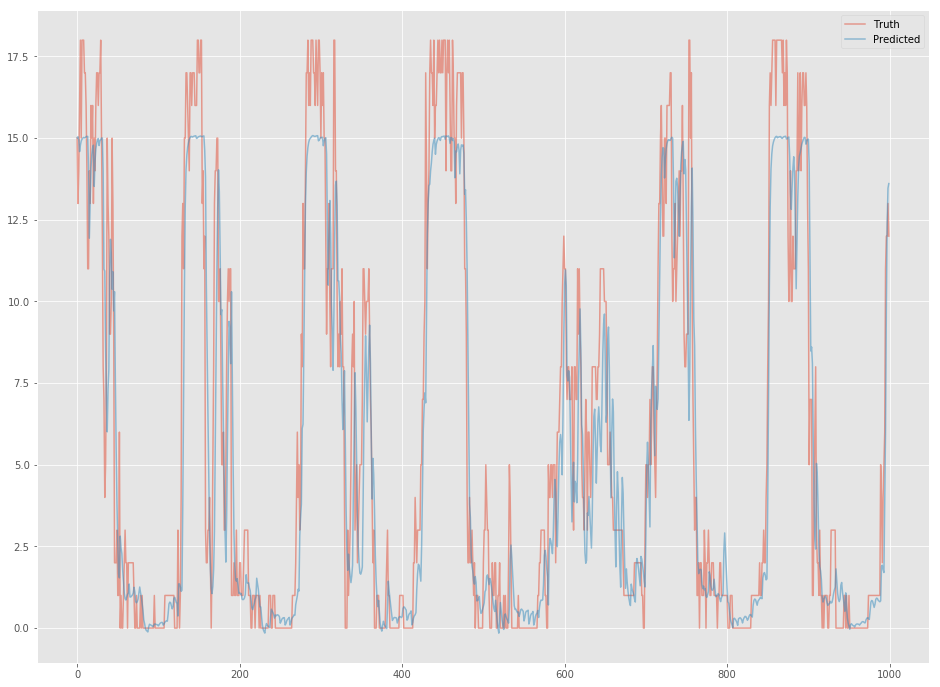

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

# Generate predictions for training
y_pred = model.predict(X_test)

fig, ax = plt.subplots(figsize=(16,12))
ax.plot(y_test[-1000:], alpha=0.5, label='Truth')
ax.plot(y_pred[-1000:], alpha=0.5, label='Predicted')
ax.legend()

This works but it is deceptive. At every time step $t$ the last $n-1$ observations that were used for predicting were known to be true. This is fine if we want to predict the next time step, however in our case we will have to predict multiple points in the future.

To do so we will have to simulate the time steps one-by-one by using a sliding window. We set an initial window to contain $k$ observations. We use these $k$ observations to predict the next obsersation. We then "slide" the window by removing the first observation and putting the predicted observation at the end of the window. After $k$ steps none of the initial observations will remain because they will have been replaced with predicted observations one-by-one.

This and other matters are illustrated in one of [Jakob Aungiers's blog posts](http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction).

## Train an RNN for each station in the test set

In [11]:
import time


station_models = {}
to_predict_df = pd.read_csv('challenge_data/test-blank.csv', index_col=0)
t0 = time.time()

for i, (station, group) in enumerate(to_predict_df.groupby('station')):
    city = group['city'][0]
    df_station = get_station_updates(city, station)
    data_station = preprocess(df_station)[-3000:]
    X_station, y_station = reshape(data_station, look_back=look_back)
    model.fit(X_station, y_station, nb_epoch=5, batch_size=64, verbose=0)
    station_models[station] = model
    print('{} - {} - {:.2f} s.'.format(i, station, time.time() - t0))

0 - 00003-pomme - 24.81 s.
1 - 00040-colombette - 47.67 s.
2 - 00055-st-sernin-g-arnoult - 70.47 s.
3 - 00065-verdier-grand-rond - 93.68 s.
4 - 00161-rangueil-bedouce - 116.74 s.
5 - 00189-muret-boutinon - 140.48 s.
6 - 00204-pl-roger-arnaud - 165.26 s.
7 - 00210-terrasse-centre-co - 188.58 s.
8 - 00229-iut-rangueil - 212.93 s.
9 - 00243-etats-unis-ferry - 237.77 s.
10 - 01020-rivoli-concorde - 261.79 s.
11 - 04013-francs-bourgeois - 286.93 s.
12 - 07008-solferino - 310.70 s.
13 - 08035-narvick - 333.31 s.
14 - 08046-alma-marceau - 356.87 s.
15 - 08101-londres-amsterdam - 381.88 s.
16 - 1-ave-e-30-st - 406.70 s.
17 - 12029-dugommier - 430.06 s.
18 - 15020-mairie-du-15eme - 454.46 s.
19 - 23001-couturier-1-levallois - 478.12 s.
20 - 3-ave-schermerhorn-st - 504.38 s.
21 - 43002-lagny-vincennes - 529.30 s.
22 - broad-st-bridge-st - 553.61 s.
23 - clinton-st-grand-st - 578.77 s.
24 - e-11-st-1-ave - 602.42 s.
25 - e-17-st-broadway - 626.58 s.
26 - exchange-place - 650.78 s.
27 - kent-ave-s

## Simulate a scenario for each station in the test set

In [12]:
import datetime as dt


scenarios = {}
t0 = time.time()

for i, (station, group) in enumerate(to_predict_df.groupby('station')):
    scenarios[station] = {}
    city = group['city'][0]
    model = station_models[station]

    # Simulate from 10:10 until 12:00 for the first day
    since = dt.datetime(year=2017, month=1, day=4, hour=10, minute=10)
    until = dt.datetime(year=2017, month=1, day=4, hour=12, minute=0)

    # Initialize a sliding window with the most recent observations
    df_station = get_station_updates(city, station)
    window = preprocess(df_station)[-look_back:].copy()

    now = since
    while now <= until:
        prediction = np.round(model.predict(window.reshape(1, look_back, n_features))[0][0])
        print(now, prediction)
        scenarios[station][now] = prediction
        now += dt.timedelta(minutes=10)
        # Update the sliding window
        window = np.append(window[1:], [[
            prediction,
            float(now.weekday()),
            float(now.hour),
            float(now.minute)
        ]], axis=0)

    print('{} - {} - {:.2f} s.'.format(i, station, time.time() - t0))

2017-01-04 10:10:00 7.0
2017-01-04 10:20:00 6.0
2017-01-04 10:30:00 6.0
2017-01-04 10:40:00 5.0
2017-01-04 10:50:00 4.0
2017-01-04 11:00:00 4.0
2017-01-04 11:10:00 5.0
2017-01-04 11:20:00 4.0
2017-01-04 11:30:00 4.0
2017-01-04 11:40:00 3.0
2017-01-04 11:50:00 3.0
2017-01-04 12:00:00 3.0
0 - 00003-pomme - 0.52 s.
2017-01-04 10:10:00 4.0
2017-01-04 10:20:00 4.0
2017-01-04 10:30:00 3.0
2017-01-04 10:40:00 3.0
2017-01-04 10:50:00 2.0
2017-01-04 11:00:00 2.0
2017-01-04 11:10:00 2.0
2017-01-04 11:20:00 2.0
2017-01-04 11:30:00 2.0
2017-01-04 11:40:00 1.0
2017-01-04 11:50:00 1.0
2017-01-04 12:00:00 1.0
1 - 00040-colombette - 1.01 s.
2017-01-04 10:10:00 11.0
2017-01-04 10:20:00 10.0
2017-01-04 10:30:00 9.0
2017-01-04 10:40:00 8.0
2017-01-04 10:50:00 7.0
2017-01-04 11:00:00 8.0
2017-01-04 11:10:00 8.0
2017-01-04 11:20:00 8.0
2017-01-04 11:30:00 8.0
2017-01-04 11:40:00 7.0
2017-01-04 11:50:00 6.0
2017-01-04 12:00:00 7.0
2 - 00055-st-sernin-g-arnoult - 1.45 s.
2017-01-04 10:10:00 20.0
2017-01-04 1

I then use these values and replace the values in the windowed average submission.